In [2]:
import numpy as np
from tqdm import tqdm
import pandas as pd
from utils import *
from env import Environment
from main import Config

# Baseline: Fictitious Play Solving Two-Agents Dilemma
Payoff matrix:

| Tables      | Cooperation |  Defection |
|-------------|:-----------:|-----------:|
| Cooperation |   REWARD    | TEMPTATION |
| Defection   |   SUCKER    | PUNISHMENT |

In [1]:
N_EPISODES = 100
EPOCH = 100
seed = 42
np.random.seed(seed)

In [4]:
def two_agent_fictitious_play(payoff:Type.TensorType, reward:Type.TensorType, strategy:Type.TensorType, belief:Type.TensorType, epsilon:float=0.05, random:bool=False):
    # exploration
    for i in range(1,10):
        strategy[i,0] = np.random.randint(0,2)
        strategy[i,1] = np.random.randint(0,2)

        # update the empirical distribution
        belief[i,0] = ((i-1)*belief[i-1,0] + strategy[i,0])/i
        belief[i,1] = ((i-1)*belief[i-1,1] + strategy[i,1])/i

    for i in range(10,N_EPISODES):
        # calculate payoff of Agent 0 assuming the other Agent plays according to empirical dist.
        reward[0,0] = belief[i-1,1]*payoff[0,1] + (1-belief[i-1,1])*payoff[0,0]
        reward[1,0] = belief[i-1,1]*payoff[1,1] + (1-belief[i-1,1])*payoff[1,0]

        # calculate payoff of Agent 1 assuming the other Agent plays according to empirical dist.
        reward[0,1] = belief[i-1,0]*payoff[0,1] + (1-belief[i-1,0])*payoff[0,0]
        reward[1,1] = belief[i-1,0]*payoff[1,1] + (1-belief[i-1,0])*payoff[1,0]

        # Agent 1's best response
        if reward[0,0] < reward[1,0]-epsilon:
            strategy[i,0] = 1
        elif reward[0,0]-epsilon > reward[1,0]:
            strategy[i,0] = 0
        else:
            strategy[i,0] = strategy[i-1,0] if random==False else np.random.randint(0,2)

        # Agent 2's best response
        if  reward[0,1] < reward[1,1]-epsilon:
            strategy[i,1] = 1
        elif reward[0,1]-epsilon > reward[1,1]:
            strategy[i,1] = 0
        else:
            strategy[i,1] = strategy[i-1,1] if random==False else np.random.randint(0,2)

        # update the empirical distribution
        belief[i,0] = ((i-1)*belief[i-1,0] + strategy[i,0])/i
        belief[i,1] = ((i-1)*belief[i-1,1] + strategy[i,1])/i

        # store the (normalized) number of iterations
        # strategy[i,2] = i/N_EPISODES
        # belief[i,2] = i/N_EPISODES
    return strategy, belief

In [109]:
def generate_payoff_matrix(name:str, REWARD=3, TEMPTATION=None, SUCKER=None, PUNISHMENT=None, N=100):
    # prisoner's dilemma rule: TEMPTATION > REWARD > PUNISHMENT > SUCKER; 2*REWARD > TEMPTATION + SUCKER
    if REWARD is not None and TEMPTATION is not None and SUCKER is not None and PUNISHMENT is not None:
        return REWARD, TEMPTATION, SUCKER, PUNISHMENT
    if name == 'PD':
        TEMPTATION = np.round(np.random.uniform(REWARD+0.01, 2*REWARD-0.01, N), decimals=2)
        x = np.ones(N)
        REWARD = REWARD * x
        SUM = np.round(np.random.uniform(TEMPTATION, 2*REWARD-0.01, N), decimals=2)
        SUCKER = SUM - TEMPTATION
        PUNISHMENT = np.round(np.random.uniform(SUCKER+0.01, REWARD-0.01, N), decimals=2)
        assert np.sum(TEMPTATION > REWARD) == N and np.sum(REWARD > PUNISHMENT) == N and np.sum(PUNISHMENT > SUCKER) == N, f'{np.sum(TEMPTATION > REWARD)} and {np.sum(REWARD > PUNISHMENT)} and {np.sum(PUNISHMENT > SUCKER)}'
        assert np.sum(2*REWARD > TEMPTATION + SUCKER) == N, f'{np.sum(2*REWARD > TEMPTATION + SUCKER)}'
        return REWARD, TEMPTATION, SUCKER, PUNISHMENT

In [110]:
# prisoner's dilemma
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 3, 5, 0, 1
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('PD', N=1000)
# stag hunt
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 4, 3, 0, 1
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 4, 4, 0, 1
# chicken
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 3, 4, 1, 0

# C:0, D:1
# payoff matrix for the two Agents in the 2x2 game

result = pd.DataFrame(columns=['Agent_1', 'Agent_2', 'Agent_1_Belief', 'Agent_2_Belief', 'temptation', 'reward', 'punishment', 'sucker'])
for idx, val in tqdm(enumerate(REWARD)):
    R, S, T, P = val, SUCKER[idx], TEMPTATION[idx], PUNISHMENT[idx]
    payoff = np.array([[R, S],[T, P]])
    strategy_list, belief_list = [],[]
    for ep in range(EPOCH):
        # 'reward' stores the payoff for each player, assuming the other player plays according to the empirical distribution
        reward = np.zeros([2,2])
        # 'strategy' stores the strategy played in each time period
        strategy = -np.ones([N_EPISODES,2])
        # 'belief' stores the empirical distribution at each time period, which is the defection probability
        belief = np.zeros([N_EPISODES,2])
        strategy, belief = two_agent_fictitious_play(payoff, reward, strategy, belief, epsilon=0)
        strategy_list.append(strategy[-1].copy())
        belief_list.append(belief[-1].copy())
    df = pd.DataFrame(np.concatenate((np.array(strategy_list),np.array(belief_list)), axis=1), columns=['Agent_1', 'Agent_2', 'Agent_1_Belief', 'Agent_2_Belief'])
    df_mean = df.mean().to_frame().transpose()
    df_mean['temptation'], df_mean['reward'], df_mean['punishment'], df_mean['sucker'] = T, R, P, S
    result = pd.concat([result, df_mean], ignore_index=True)
result

1000it [02:04,  8.01it/s]


,Agent_1,Agent_2,Agent_1_Belief,Agent_2_Belief,temptation,reward,punishment,sucker
0,1.0,1.0,0.951919,0.954747,4.11,3.0,1.84,0.80
1,1.0,1.0,0.955455,0.955051,5.26,3.0,2.93,0.37
2,1.0,1.0,0.954444,0.953434,3.16,3.0,2.62,2.06
3,1.0,1.0,0.955758,0.956465,4.01,3.0,2.82,1.02
4,1.0,1.0,0.953636,0.956869,3.31,3.0,0.89,0.67
...,...,...,...,...,...,...,...,...
995,1.0,1.0,0.953333,0.954747,3.04,3.0,2.09,1.40
996,1.0,1.0,0.954242,0.952727,3.77,3.0,1.61,0.62
997,1.0,1.0,0.952626,0.954545,5.09,3.0,2.57,0.44
998,1.0,1.0,0.955253,0.956869,4.44,3.0,2.36,1.50


PD results

<AxesSubplot:ylabel='Frequency'>

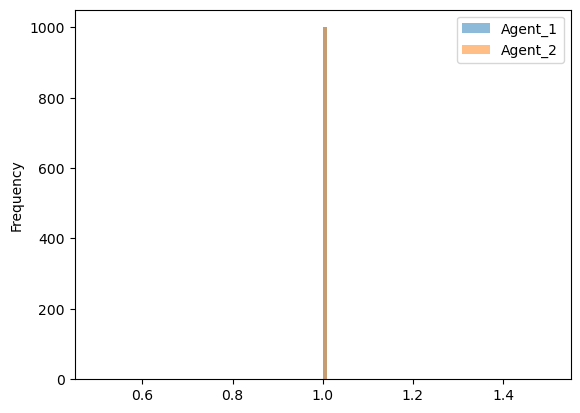

In [121]:
result[['Agent_1', 'Agent_2']].plot.hist(bins=100, alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

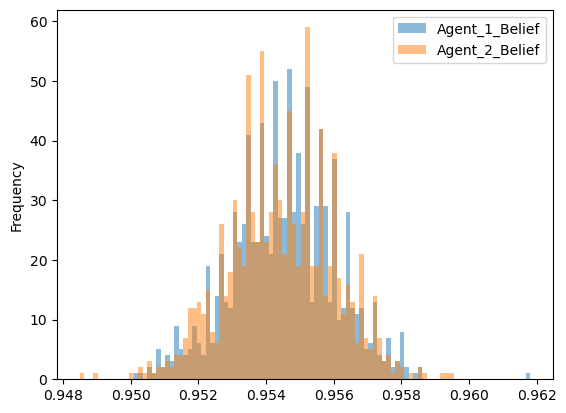

In [120]:
result[['Agent_1_Belief', 'Agent_2_Belief']].plot.hist(bins=100, alpha=0.5)

### Generalized into N-Agent Version

In [177]:
def multi_agent_fictitious_play(payoff:Type.TensorType, reward:Type.TensorType, strategy:Type.TensorType, belief:Type.TensorType, N:int, alpha:float=0.05, epsilon:float=0.05, random:bool=False):
    def random_select_partner(N:int, n:int):
        m = n
        while m == n:
            m = np.random.randint(0, N)
        return m

    assert strategy.shape == (N_EPISODES, N), "strategy columns should be N"

    log=dict()
    # exploration
    for i in range(1,10):
        n = np.random.randint(0, N)
        m = random_select_partner(N,n)

        strategy[i,n] = np.random.randint(0,2)
        strategy[i,m] = np.random.randint(0,2)

        # update the empirical distribution
        belief[n] = (1-alpha)*belief[n] + alpha*strategy[i,n]
        belief[m] = (1-alpha)*belief[m] + alpha*strategy[i,m]
        log[i] = {n:belief[n],m:belief[m]}

    for i in range(10,N_EPISODES):
        n = np.random.randint(0, N)
        m = random_select_partner(N,n)

        # calculate payoff of Agent 0 assuming the other Agent plays according to empirical dist.
        reward[0,0] = belief[m]*payoff[0,1] + (1-belief[m])*payoff[0,0]
        reward[1,0] = belief[m]*payoff[1,1] + (1-belief[m])*payoff[1,0]

        # calculate payoff of Agent 1 assuming the other Agent plays according to empirical dist.
        reward[0,1] = belief[n]*payoff[0,1] + (1-belief[n])*payoff[0,0]
        reward[1,1] = belief[n]*payoff[1,1] + (1-belief[n])*payoff[1,0]

        # Agent 1's best response
        if reward[0,0] < reward[1,0]-epsilon:
            strategy[i,n] = 1
        elif reward[0,0]-epsilon > reward[1,0]:
            strategy[i,n] = 0
        else:
            strategy[i,n] = np.random.randint(0,2)

        # Agent 2's best response
        if  reward[0,1] < reward[1,1]-epsilon:
            strategy[i,m] = 1
        elif reward[0,1]-epsilon > reward[1,1]:
            strategy[i,m] = 0
        else:
            strategy[i,m] = np.random.randint(0,2)

        print('error') if strategy[i,n]<0 or strategy[i,m]<0 else None

        # update the empirical distribution
        belief[n] = (1-alpha)*belief[n] + alpha*strategy[i,n]
        belief[m] = (1-alpha)*belief[m] + alpha*strategy[i,m]
        log[i] = {n:belief[n],m:belief[m]}
        # store the (normalized) number of iterations
        # strategy[i,2] = i/N_EPISODES
        # belief[i,2] = i/N_EPISODES
    return strategy, belief, log

In [181]:
# prisoner's dilemma
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 3, 5, 0, 1
# stag hunt
REWARD, TEMPTATION, SUCKER, PUNISHMENT = 4, 3, 0, 1
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 4, 4, 0, 1
# chicken
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 3, 4, 1, 0

N = 3
# C:0, D:1
# payoff matrix for the two players in the 2x2 game
payoff = np.array([[REWARD, SUCKER],[TEMPTATION, PUNISHMENT]])
strategy_list, belief_list = [],[]
for ep in tqdm(range(EPOCH)):
    # 'reward' stores the payoff for each player, assuming the other player plays according to the empirical distribution
    reward = np.zeros([2,2])
    # 'strategy' stores the strategy played in each time period
    strategy = -np.ones([N_EPISODES,N])
    # 'belief' stores the empirical distribution at each time period, which is the defection probability
    belief = np.zeros(N)
    strategy, belief, belief_value = multi_agent_fictitious_play(payoff, reward, strategy, belief, N)
    strategy_list.append(strategy[-1].copy())
    belief_list.append(belief.copy())

columns = []
for i in range(N):
    columns.append(f'Agent_{i+1}')
for i in range(N):
    columns.append(f'Agent_{i+1}_Defection')

df = pd.DataFrame(np.concatenate((np.array(strategy_list),np.array(belief_list)), axis=1), columns=columns)
df.describe()

100%|██████████| 100/100 [00:00<00:00, 374.10it/s]


,Agent_1,Agent_2,Agent_3,Agent_1_Defection,Agent_2_Defection,Agent_3_Defection
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.290000,-0.380000,-0.330000,0.006370,0.006026,0.006079
std,0.456048,0.487832,0.472582,0.003483,0.003260,0.003270
min,-1.000000,-1.000000,-1.000000,0.000000,0.001452,0.000000
25%,-1.000000,-1.000000,-1.000000,0.004255,0.003658,0.003790
50%,0.000000,0.000000,0.000000,0.005946,0.005356,0.006011
75%,0.000000,0.000000,0.000000,0.007563,0.008158,0.007938
max,0.000000,0.000000,0.000000,0.023418,0.019074,0.016133


In [179]:
belief_value

{1: {1: 0.0, 0: 0.05},
 2: {0: 0.0975, 2: 0.05},
 3: {1: 0.0, 2: 0.0975},
 4: {1: 0.0, 0: 0.092625},
 5: {2: 0.142625, 1: 0.0},
 6: {1: 0.0, 2: 0.18549375},
 7: {1: 0.0, 0: 0.13799375},
 8: {1: 0.05, 2: 0.2262190625},
 9: {0: 0.18109406249999999, 2: 0.214908109375},
 10: {0: 0.22203935937499997, 2: 0.25416270390625},
 11: {2: 0.24145456871093748, 1: 0.0975},
 12: {0: 0.26093739140624994, 2: 0.2793818402753906},
 13: {2: 0.315412748261621, 1: 0.142625},
 14: {1: 0.18549375, 0: 0.29789052183593745},
 15: {2: 0.34964211084853997, 0: 0.33299599574414057},
 16: {2: 0.38216000530611294, 1: 0.2262190625},
 17: {0: 0.3663461959569335, 1: 0.264908109375},
 18: {2: 0.41305200504080725, 1: 0.30166270390624994},
 19: {1: 0.3365795687109374, 2: 0.4423994047887669},
 20: {1: 0.36975059027539053, 0: 0.3980288861590868},
 21: {1: 0.401263060761621, 0: 0.42812744185113244},
 22: {0: 0.4567210697585758, 1: 0.4311999077235399},
 23: {1: 0.45963991233736284, 2: 0.4702794345493285},
 24: {1: 0.486657916720